In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
%matplotlib inline

# ignore pandas warnings
import warnings
warnings.simplefilter('ignore')

import pickle
import time
start = time.time()

In [2]:
# sklearn imports
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error

# xgboost
from xgboost import XGBRegressor

# custom 'library'
from aux_fun import plot_learning_curve, plot_validation_curve

Retrieve data from the previous stage:

In [3]:
with open('data_train_test.p', 'rb') as handle:
    data_train_test = pickle.load(handle)
    
x_train, y_train = data_train_test['train']
x_test, y_test = data_train_test['test']

sorted_feat_importances = pd.read_excel('feature_importances.xlsx')

Redefine model:

In [4]:
kf = KFold(n_splits=5)
xgb = XGBRegressor(max_depth=20,learning_rate=0.1,n_estimators=100,subsample=0.9)

Cross validate to get optimal number of features:

In [5]:
mae_cv_path = list()
mae_std_cv_path = list()
n_path = np.arange(1,40).tolist()
for n in n_path:
    start_iter = time.time()
    subset = sorted_feat_importances.iloc[:n].index.tolist()
    mae = np.abs(cross_val_score(xgb, X=x_train[:,subset], y=y_train, scoring='mean_absolute_error', cv=kf, n_jobs=-1))
    mae_cv_path.append(mae.mean())
    mae_std_cv_path.append(mae.std())
    print('Step %i done (%0.2f s)' % (n,time.time() - start_iter))

Step 1 done (2.43 s)
Step 2 done (2.50 s)
Step 3 done (3.01 s)
Step 4 done (2.99 s)
Step 5 done (3.08 s)
Step 6 done (3.34 s)
Step 7 done (3.45 s)
Step 8 done (3.53 s)
Step 9 done (3.72 s)
Step 10 done (3.80 s)
Step 11 done (3.99 s)
Step 12 done (3.96 s)
Step 13 done (4.13 s)
Step 14 done (4.22 s)
Step 15 done (4.32 s)
Step 16 done (4.43 s)
Step 17 done (4.41 s)
Step 18 done (4.54 s)
Step 19 done (4.77 s)
Step 20 done (5.00 s)
Step 21 done (4.98 s)
Step 22 done (5.35 s)
Step 23 done (5.33 s)
Step 24 done (5.31 s)
Step 25 done (5.41 s)
Step 26 done (5.53 s)
Step 27 done (5.52 s)
Step 28 done (5.62 s)
Step 29 done (5.69 s)
Step 30 done (5.90 s)
Step 31 done (5.99 s)
Step 32 done (5.96 s)
Step 33 done (6.19 s)
Step 34 done (6.31 s)
Step 35 done (6.32 s)
Step 36 done (6.39 s)
Step 37 done (6.59 s)
Step 38 done (6.77 s)
Step 39 done (6.83 s)


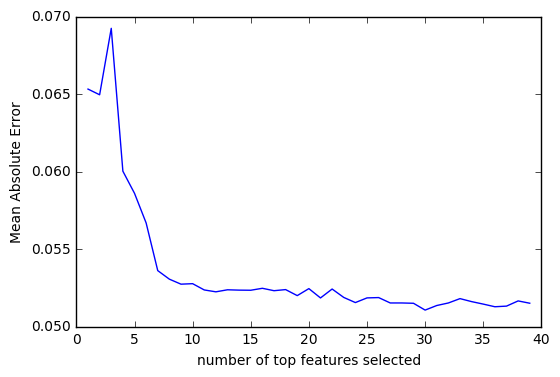

In [6]:
plt.plot(n_path,mae_cv_path)
plt.ylabel('Mean Absolute Error')
plt.xlabel('number of top features selected');

In [7]:
min_mae = np.inf
n_min_mae = None
for (mae,n) in zip(mae_cv_path,n_path):
    if mae < min_mae:
        min_mae = mae
        n_min_mae = n
        
print('Optimal n features: %i (MAE = %0.5f)' % (n_min_mae, min_mae))

Optimal n features: 30 (MAE = 0.05106)


In [8]:
select_top = n_min_mae
most_important_feat_indices = sorted_feat_importances.iloc[:select_top].index.tolist()

In [9]:
x_train_reduced = x_train[:,most_important_feat_indices]
x_test_reduced = x_test[:,most_important_feat_indices]

Fit whole train set with best hyperparameter

In [10]:
xgb.fit(x_train_reduced,y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=20,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.9)

In [11]:
print('Test mean abs error: ', mean_absolute_error(y_test, xgb.predict(x_test_reduced)))

Test mean abs error:  0.0487906130947


## Model assessment

In [12]:
# Compute true errors
w_true = np.exp(y_test) - 1
w_pred = np.exp(xgb.predict(x_test_reduced)) - 1
abs_error = np.absolute(w_true - w_pred)
mean_abs_error = abs_error.mean()
pct_error = abs_error / w_true

# true test set errors
print('Mean absolute error: %0.4f' % mean_abs_error)
print('Mean relative error: %0.4f' % pct_error.mean())

Mean absolute error: 0.2078
Mean relative error: 0.0639


In [13]:
time.time() - start

189.68222618103027